In [1]:
%matplotlib inline

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from sentinel1Etad import Sentinel1Etad, ECorrectionType
import sentinel1Etad as s1etad

# *sentinel1Etad* Python module: basic usage

## Sentinel1Etad product

In [3]:
filename = 'test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE'
eta_ = Sentinel1Etad(filename)

In [4]:
eta_

Sentinel1Etad("test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE")  # 0x7fcf351d4b10
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20190805T162509_20190805T162536_017453_020D3A_A857.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Grid sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

### Check which corrections have been enabled

In [5]:
eta_.processing_setting()

{'troposphericDelayCorrection': True,
 'ionosphericDelayCorrection': True,
 'solidEarthTideCorrection': True,
 'bistaticAzimuthCorrection': True,
 'dopplerShiftRangeCorrection': True,
 'FMMismatchAzimuthCorrection': True}

### The burst catalogue

It is a pandas dataframe to allow easy filtering.

See also use cases in the "Use case 1: Selecting the bursts" section for a more complete explaination on the burst catalogue and the query mechanism.

In [6]:
eta_.burst_catalogue.head()

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
3,10,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
4,13,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229


**Tip**: the total number of bursts in a product can be retrieved as follows:

In [7]:
print('Total number of bursts:', len(eta_.burst_catalogue))

Total number of bursts: 27


## Swath objects

### How many swaths are stored in a product?

In [8]:
print('Number of swaths:', eta_.number_of_swath)
print('Swath list:', eta_.swath_list)

Number of swaths: 3
Swath list: ['IW1', 'IW2', 'IW3']


### How to retieve a Sentinel1EtadSwath object

In [9]:
swath = eta_['IW2']

In [10]:
swath

Sentinel1EtadSwath("/IW2")  0x7fcf35e6a210
Swaths ID: IW2
Number of bursts: 9
Burst list: [2, 5, 8, 11, 14, 17, 20, 23, 26]
Sampling start:
  x: 0.0003095178536924219
  y: 0.9208892223996372
  units: s
Sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  units: s

## Burst objects

In [11]:
burst = swath[2]

In [12]:
burst

Sentinel1EtadBurst("/IW2/Burst0002")  0x7fcf35e6add0
Swaths ID: IW2
Burst index: 2
Shape: (112, 523)
Sampling start:
  x: 0.0003095178536924219
  y: 0.9208892223996372
  units: s
Sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  units: s

**NOTE**: one can only get bursts whose index is present in the "burst list" of the swath

In [13]:
swath.burst_list

[2, 5, 8, 11, 14, 17, 20, 23, 26]

In [14]:
try:
    swath[1]
except IndexError as exc:
    print('ERROR: Ops someting went wrong:', repr(exc))

ERROR: Ops someting went wrong: IndexError('Burst0001 not found in /IW2')


## String representation

Please note that the string representation of Sentinel1Etad object is a "one-line" string providing only basic information:

In [15]:
print('Product:', str(eta_))
print('Swath:', str(swath))
print('Burst:', str(burst))

Product: Sentinel1Etad("S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE")
Swath: Sentinel1EtadSwath("/IW2")  0x7fcf35e6a210
Burst: Sentinel1EtadBurst("/IW2/Burst0002")  0x7fcf35e6add0


Anyway in Jupyer environments a richer representation is also available:

In [16]:
eta_

Sentinel1Etad("test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE")  # 0x7fcf351d4b10
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20190805T162509_20190805T162536_017453_020D3A_A857.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Grid sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

## Iteration

It is possible to iterate over products and swats in the same way one does it with any ather python container.

In [17]:
for swath in eta_:
    print(swath)
    for burst in swath:
        print(burst.burst_index, burst.swath_id, burst)
    print()

Sentinel1EtadSwath("/IW1")  0x7fcf35e7d110
1 IW1 Sentinel1EtadBurst("/IW1/Burst0001")  0x7fcf35e7d1d0
4 IW1 Sentinel1EtadBurst("/IW1/Burst0004")  0x7fcf35e7d710
7 IW1 Sentinel1EtadBurst("/IW1/Burst0007")  0x7fcf35e7db10
10 IW1 Sentinel1EtadBurst("/IW1/Burst0010")  0x7fcf35e7d610
13 IW1 Sentinel1EtadBurst("/IW1/Burst0013")  0x7fcf35e7d490
16 IW1 Sentinel1EtadBurst("/IW1/Burst0016")  0x7fcf35e7db90
19 IW1 Sentinel1EtadBurst("/IW1/Burst0019")  0x7fcf35e7d950
22 IW1 Sentinel1EtadBurst("/IW1/Burst0022")  0x7fcf35e7ddd0
25 IW1 Sentinel1EtadBurst("/IW1/Burst0025")  0x7fcf35e7ded0

Sentinel1EtadSwath("/IW2")  0x7fcf35e6a210
2 IW2 Sentinel1EtadBurst("/IW2/Burst0002")  0x7fcf35e6add0
5 IW2 Sentinel1EtadBurst("/IW2/Burst0005")  0x7fcf35e7de50
8 IW2 Sentinel1EtadBurst("/IW2/Burst0008")  0x7fcf35e7e190
11 IW2 Sentinel1EtadBurst("/IW2/Burst0011")  0x7fcf35e7e290
14 IW2 Sentinel1EtadBurst("/IW2/Burst0014")  0x7fcf35e7e390
17 IW2 Sentinel1EtadBurst("/IW2/Burst0017")  0x7fcf35e7e490
20 IW2 Sentinel1Eta

### How to iterate only on selected items

It is also possible to iterate on a sub-set of the products swaths (or a sub-set of the swath bursts):

In [18]:
for swath in eta_.iter_swaths(['IW1', 'IW2']):  # no 'IW3'
    # list of bursts
    odd_bursts = [idx for idx in swath.burst_list if idx % 2 != 0]
    for burst in swath.iter_bursts(odd_bursts):
        print(f'{burst.burst_index:2} {burst.swath_id} {burst}')

 1 IW1 Sentinel1EtadBurst("/IW1/Burst0001")  0x7fcf35e7d1d0
 7 IW1 Sentinel1EtadBurst("/IW1/Burst0007")  0x7fcf35e7db10
13 IW1 Sentinel1EtadBurst("/IW1/Burst0013")  0x7fcf35e7d490
19 IW1 Sentinel1EtadBurst("/IW1/Burst0019")  0x7fcf35e7d950
25 IW1 Sentinel1EtadBurst("/IW1/Burst0025")  0x7fcf35e7ded0
 5 IW2 Sentinel1EtadBurst("/IW2/Burst0005")  0x7fcf35e7de50
11 IW2 Sentinel1EtadBurst("/IW2/Burst0011")  0x7fcf35e7e290
17 IW2 Sentinel1EtadBurst("/IW2/Burst0017")  0x7fcf35e7e490
23 IW2 Sentinel1EtadBurst("/IW2/Burst0023")  0x7fcf35e7e690


### How to iterate on query results

The query mechanism is explained extensively in the following.

Queries can be performed using the `Sentinel1Etad.query_burst` method.

A simple example is a query for a specific swath:

In [19]:
query_result = eta_.query_burst(swath='IW3')

for swath in eta_.iter_swaths(query_result):
    for burst in swath.iter_bursts(query_result):
        print(burst)

Sentinel1EtadBurst("/IW3/Burst0003")  0x7fcf35e7e710
Sentinel1EtadBurst("/IW3/Burst0006")  0x7fcf35e7e990
Sentinel1EtadBurst("/IW3/Burst0009")  0x7fcf35e7eb10
Sentinel1EtadBurst("/IW3/Burst0012")  0x7fcf35e7ec10
Sentinel1EtadBurst("/IW3/Burst0015")  0x7fcf35e7ed10
Sentinel1EtadBurst("/IW3/Burst0018")  0x7fcf35e7ee10
Sentinel1EtadBurst("/IW3/Burst0021")  0x7fcf35e7ee90
Sentinel1EtadBurst("/IW3/Burst0024")  0x7fcf35e82050
Sentinel1EtadBurst("/IW3/Burst0027")  0x7fcf35e82150


# Use cases for the Sentinel1Etad class

## Use case 1 : Selecting the bursts

### Selecting the burst by filtering in time

The availability of the burst catalogue, allows to perform queries and filter the burst by performing time selection using the __first_time__ and __last_time__ keywords of the __query_burst__ method.

If no time is provided then all the burst are selected:

In [20]:
df = eta_.query_burst()

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 27


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671


It is possible to reduce the selection by **start time** in this case the **stop time** is the last available burst:

In [21]:
from dateutil import parser
first_time = parser.parse('2019-08-05T16:25:30.117898')

df = eta_.query_burst(first_time=first_time)

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 4


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
25,24,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:31.017231,2019-08-05 16:25:34.240344
8,25,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:31.880565,2019-08-05 16:25:35.046122
17,26,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:32.830232,2019-08-05 16:25:36.024566
26,27,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:33.779899,2019-08-05 16:25:36.974233


It is possible to reduce the selection by the **stop time** in this case the **start time** is the first available burst:

In [22]:
last_time =  parser.parse('2019-08-05T16:25:20.117899')

df = eta_.query_burst(last_time=last_time)

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 8


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671


It is possible to reduce the selection by the **start** and **stop time**:

In [23]:
first_time = parser.parse('2019-08-05T16:25:25.117898')
last_time =  parser.parse('2019-08-05T16:25:29.117899')

# query the catalogues for of all the swaths
df = eta_.query_burst(first_time=first_time, last_time=last_time)
print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 1


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
23,18,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:25.520674,2019-08-05 16:25:28.715008


### Selecting by swath (and time)

The time selection can be combined with a selection by swath using the __swath__ keyword.
If not used all the swath are used

In [24]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

# query the catalogue for a subset of the swaths
df = eta_.query_burst(first_time=first_time, last_time=last_time, swath='IW1')
print(f"Number of bursts: {len(df)}")
df

Number of bursts: 9


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
3,10,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
4,13,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229
5,16,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:23.621340,2019-08-05 16:25:26.786896
6,19,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:26.355230,2019-08-05 16:25:29.549564
7,22,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:29.117897,2019-08-05 16:25:32.283454
8,25,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:31.880565,2019-08-05 16:25:35.046122


Query the catalogue for a subset of the swaths:

In [25]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

df = eta_.query_burst(first_time=first_time, last_time=last_time, swath=['IW1', 'IW2'])

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 18


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893


### Selecting by Sentinel-1 product name (swath and time)

The **time** selection can be combined with a selection by **swath** using the **product_name** keyword.

In [26]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

product_name='S1B_IW_SLC__1SDV_20190805T162509_20190805T162536_017453_020D3A_AAAA.SAFE'
df = eta_.query_burst(first_time=first_time, last_time=last_time, product_name=product_name, swath=['IW3'])

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 9


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
19,6,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:14.470003,2019-08-05 16:25:17.693115
20,9,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:17.232671,2019-08-05 16:25:20.427005
21,12,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:19.995338,2019-08-05 16:25:23.189673
22,15,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:22.758006,2019-08-05 16:25:25.952341


## Use case 2 : Retrieving the corrections

The Sentinel1EtadBurst class allows to access the netcdf product to retrieve the corrections burst by burst.

The recommented way to retrieve a correction is:

```python
s1etad.Sentinel1EtadBurst.get_correction(name, set_auto_mask=False,
                                         transpose=True, meter=False)
```

Available correction types are:

In [27]:
s1etad.ECorrectionType.__members__

mappingproxy({'TROPOSPHERIC': <ECorrectionType.TROPOSPHERIC: 'tropospheric'>,
              'IONOSPHERIC': <ECorrectionType.IONOSPHERIC: 'ionospheric'>,
              'GEODETIC': <ECorrectionType.GEODETIC: 'geodetic'>,
              'BISTATIC': <ECorrectionType.BISTATIC: 'bistatic'>,
              'DOPPLER': <ECorrectionType.DOPPLER: 'doppler'>,
              'FMRATE': <ECorrectionType.FMRATE: 'fmrate'>,
              'SUM': <ECorrectionType.SUM: 'sum'>})

**Example**:

In [28]:
# correction = burst.get_correction('ionospheric')
#
# or equivalently
correction = burst.get_correction(s1etad.ECorrectionType.IONOSPHERIC, meter=True)
correction.keys()

dict_keys(['x', 'unit', 'name'])

Text(0.5, 1.0, 'ionospheric correction (swath IW3 burst 27)')

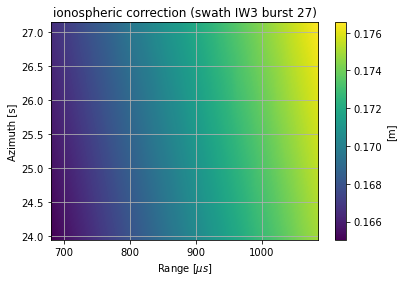

In [29]:
az, rg = burst.get_burst_grid()
extent = [rg[0]*1e6, rg[-1]*1e6, az[0], az[-1]]

plt.figure()
plt.imshow(correction['x'], extent=extent, aspect='auto')
plt.xlabel('Range [$\mu s$]')
plt.ylabel('Azimuth [s]')
plt.grid()
plt.colorbar().set_label(f'[{correction["unit"]}]')
plt.title(f'{correction["name"]} correction (swath {burst.swath_id} burst {burst.burst_index})')

In alternative, the following (**deprecated**) methods are available:

```python
get_tropospheric_correction(set_auto_mask=False, transpose=True, meter=False)
get_ionospheric_correction(set_auto_mask=False, transpose=True, meter=False)
get_geodetic_correction(set_auto_mask=False, transpose=True, meter=False)
get_bistatic_correction(set_auto_mask=False, transpose=True, meter=False)
get_doppler_correction(set_auto_mask=False, transpose=True, meter=False)
get_fmrate_correction(set_auto_mask=False, transpose=True, meter=False)
get_sum_correction(set_auto_mask=False, transpose=True, meter=False)
```

### Retrieving merged corrections

The `Sentinel1Etad` and `Sentinel1EtadSwath` classes provides methods to retrieve a specific correction for multiple bursts merged together for easy reperesentation purposes.

**NOTE**: the current implementation uses a very simple argorithm that iterates over selected bursts and stitches correction data together. In overlapping regions new data simpy overwrite the old ones.  This is an easy algorithm and perfectly correct for atmospheric and geodetic correction. It is, instead, sub-optimal for stsyem corrections (bi-static, Doppler, FM Rate) which have different values in overlapping regions.

In [30]:
# First select you burst
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

# query the catalogue for a subset of the swaths
product_name='S1B_IW_SLC__1SDV_20190805T162509_20190805T162536_017453_020D3A_AAAA.SAFE'
df = eta_.query_burst(first_time=first_time, last_time=last_time, product_name=product_name)
# df = df[df.bIndex != 13]   # exclude burst n. 13 (IW1)) to test extended selection capabilities
# df = df[df.bIndex != 17]   # exclude burst n. 17 (IW2)) to test extended selection capabilities
# df = df[df.bIndex != 15]   # exclude burst n. 17 (IW3)) to test extended selection capabilities

In [31]:
# common variables
dy = eta_.grid_spacing['y']
dx = eta_.grid_sampling['x'] * constants.c / 2
nswaths = len(df.swathID.unique())
vg = eta_.grid_spacing['y'] / eta_.grid_sampling['y']
vmin = 2.5
vmax = 3.5
to_km = 1. / 1000

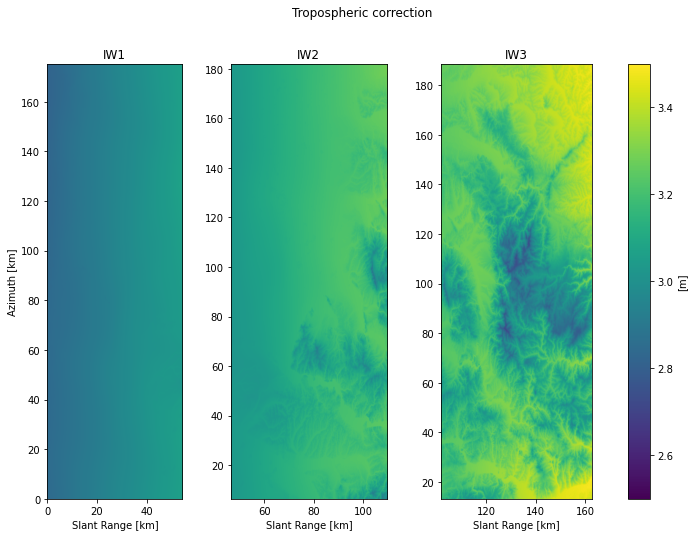

In [32]:
# iterate on swath to get de-bursted data (selected burst merged together)
fig, ax = plt.subplots(nrows=1, ncols=nswaths, figsize=[13, 8]) # , sharey='row')
for six, swath_ in enumerate(eta_.iter_swaths(df)):
    merged_correction = swath_.merge_correction(ECorrectionType.TROPOSPHERIC,
                                                selection=df, meter=True)
    merged_correction_data = merged_correction['x']
    
    ysize, xsize = merged_correction_data.shape
    x0 = merged_correction['first_slant_range_time'] * constants.c / 2  # [m]
    y0 = merged_correction['first_azimuth_time'] * vg                   # [m]
    x_axis = (x0 + np.arange(xsize) * dx) * to_km
    y_axis = (y0 + np.arange(ysize) * dy) * to_km

    extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]
    im = ax[six].imshow(merged_correction_data, origin='lower', extent=extent,
                        vmin=vmin, vmax=vmax, aspect='equal')
    ax[six].set_title(swath_.swath_id)
    ax[six].set_xlabel('Slant Range [km]')

ax[0].set_ylabel('Azimuth [km]')

name = merged_correction['name']
unit = merged_correction['unit']

fig.suptitle(f'{name.title()} correction')
fig.colorbar(im, ax=ax[:].tolist(), label=f'[{unit}]')

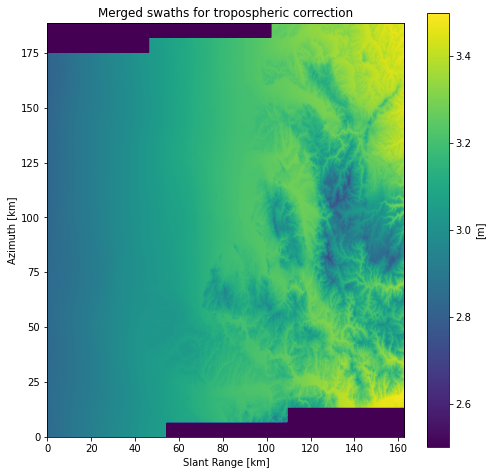

In [33]:
# get merged swaths
fig, ax = plt.subplots(figsize=[8, 8])
merged_correction = eta_.merge_correction(ECorrectionType.TROPOSPHERIC,
                                          selection=df, meter=True)
merged_correction_data = merged_correction['x']

ysize, xsize = merged_correction_data.shape
x_axis = np.arange(xsize) * dx * to_km
y_axis = np.arange(ysize) * dy * to_km      

extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]
im = ax.imshow(merged_correction_data, origin='lower', extent=extent,
               vmin=vmin, vmax=vmax, aspect='equal')

ax.set_xlabel('Slant Range [km]')
ax.set_ylabel('Azimuth [km]')

name = merged_correction['name']
unit = merged_correction['unit']

ax.set_title(f'Merged swaths for {name} correction')
fig.colorbar(im, ax=ax, label=f'[{unit}]')

## Use case 3 : Retrieving the footprints

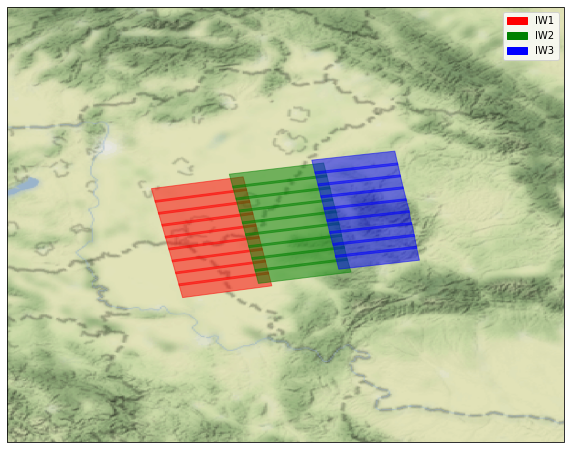

In [34]:
import cartopy.crs as ccrs
from matplotlib import patches as mpatches
from shapely.geometry import MultiPolygon

def tile_extent(poly, margin=2):
    bb = list(poly.bounds)
    bb [1:3] = bb [2:0:-1]
    bb2 = np.asarray(bb) + [-margin, margin, -margin, margin]
    return bb2

# get the footprints of the selected bursts
polys = eta_.get_footprint(swath_list=['IW1', 'IW2', 'IW3'])

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(polys)))

# Put a background image on for nice sea rendering.
OFFLINE = False
if OFFLINE:
    import cartopy.feature as cfeature
    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
else:
    import cartopy.io.img_tiles as cimgt
    stamen_terrain = cimgt.Stamen('terrain-background')
    ax.add_image(stamen_terrain, 6)  # up to 10
    ax.coastlines()

# plot footprints of all selected burst
# ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.8)

# get the footprints of each swath and plot them with different colors
items = []
for swath, color in zip(eta_, ['red', 'green', 'blue']):
    polys = swath.get_footprint()
    item = ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.5,
                             color=color)
    items.append(item)

handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(['red', 'green', 'blue'], eta_.swath_list)
]
plt.legend(handles=handles)